<a href="https://colab.research.google.com/github/JonatanPolanco/ML_Projects/blob/main/MLzoomcamp_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd

#**Data Preparation** ✅

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

In [3]:
!wget $data

--2021-11-30 03:33:52--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.06s   

2021-11-30 03:33:52 (24.9 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [11]:
df = pd.read_csv(data)

In [15]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [16]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [23]:
strings = list(df.dtypes[df.dtypes == 'object'].index)
strings

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

In [24]:
for col in strings:
  df[col] = df[col].str.lower().str.replace(' ', '_')

In [25]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


#**Exploratory data analysis** ✅





In [29]:
for col in df.columns:
  print(col)
  print(df[col].unique()[:5])
  print(df[col].nunique())
  print()

make
['bmw' 'audi' 'fiat' 'mercedes-benz' 'chrysler']
48

model
['1_series_m' '1_series' '100' '124_spider' '190-class']
914

year
[2011 2012 2013 1992 1993]
28

engine_fuel_type
['premium_unleaded_(required)' 'regular_unleaded'
 'premium_unleaded_(recommended)' 'flex-fuel_(unleaded/e85)' 'diesel']
10

engine_hp
[335. 300. 230. 320. 172.]
356

engine_cylinders
[ 6.  4.  5.  8. 12.]
9

transmission_type
['manual' 'automatic' 'automated_manual' 'direct_drive' 'unknown']
5

driven_wheels
['rear_wheel_drive' 'front_wheel_drive' 'all_wheel_drive'
 'four_wheel_drive']
4

number_of_doors
[ 2.  4.  3. nan]
3

market_category
['factory_tuner,luxury,high-performance' 'luxury,performance'
 'luxury,high-performance' 'luxury' 'performance']
71

vehicle_size
['compact' 'midsize' 'large']
3

vehicle_style
['coupe' 'convertible' 'sedan' 'wagon' '4dr_hatchback']
16

highway_mpg
[26 28 27 25 24]
59

city_mpg
[19 20 18 17 16]
69

popularity
[3916 3105  819  617 1013]
48

msrp
[46135 40650 36350 29450 345

###Distribution of price

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

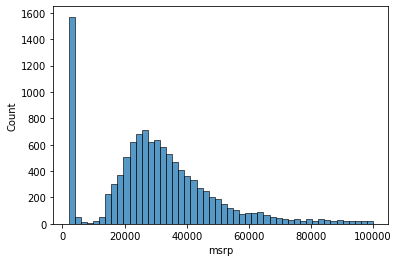

In [35]:
sns.histplot(df.msrp[df.msrp < 100000], bins=50)  #Long tail distribution (Not good for ML). So, we need to apply another distribution

In [36]:
#Logaritmic distribution
np.log1p([0 , 10, 1000, 100000]) #Log of 0 doesn´t exist so we use log1p which adds 1 to all values

array([ 0.        ,  2.39789527,  6.90875478, 11.51293546])

In [37]:
price_logs = np.log1p(df.msrp)

In [38]:
price_logs

0        10.739349
1        10.612779
2        10.500977
3        10.290483
4        10.448744
           ...    
11909    10.739024
11910    10.945018
11911    10.832122
11912    10.838031
11913    10.274913
Name: msrp, Length: 11914, dtype: float64

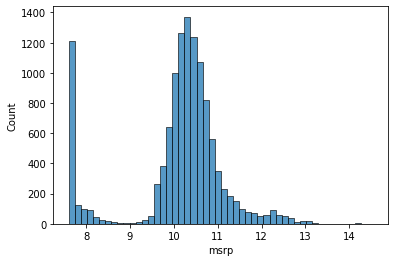

In [39]:
sns.histplot(price_logs, bins=50) #Looks like normal distribution (ideal to models)

###Missing values (nan)

In [42]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

#**Setting up the validation framework**
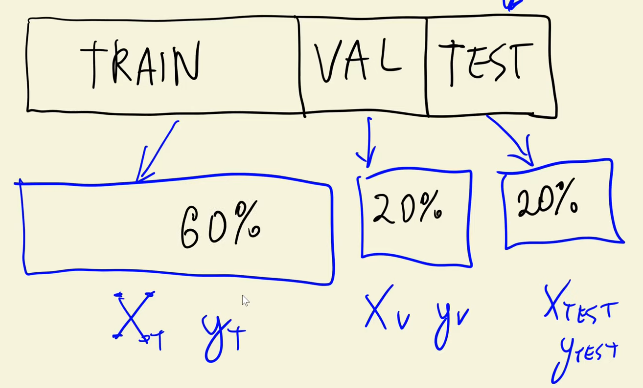

In [50]:
n = len(df)
n_val = int(len(df) * 0.2)
n_test = int(len(df) * 0.2)
n_train = n - n_val - n_test # 60% of df

In [58]:
n_train, n_val, n_test

(7150, 2382, 2382)

In [57]:
n, n_val + n_test + n_train

(11914, 11914)

In [72]:
#We need to shuffle the data to get diferent values in train, test and val df's
np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

In [83]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [84]:
df_train

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
2735,chevrolet,cobalt,2008,regular_unleaded,148.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,33,24,1385,14410
6720,toyota,matrix,2012,regular_unleaded,132.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,32,25,2031,19685
5878,subaru,impreza,2016,regular_unleaded,148.0,4.0,automatic,all_wheel_drive,4.0,hatchback,compact,4dr_hatchback,37,28,640,19795
11190,volkswagen,vanagon,1991,regular_unleaded,90.0,4.0,manual,rear_wheel_drive,3.0,NaN,large,passenger_minivan,18,16,873,2000
4554,ford,f-150,2017,flex-fuel_(unleaded/e85),385.0,8.0,automatic,four_wheel_drive,4.0,flex_fuel,large,crew_cab_pickup,21,15,5657,56260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,bmw,4_series,2015,premium_unleaded_(required),300.0,6.0,automatic,rear_wheel_drive,2.0,"luxury,performance",midsize,convertible,31,20,3916,54900
1902,volkswagen,beetle,2015,premium_unleaded_(recommended),210.0,4.0,automated_manual,front_wheel_drive,2.0,"hatchback,performance",compact,2dr_hatchback,30,24,873,29215
9334,gmc,sierra_1500,2015,flex-fuel_(unleaded/e85),285.0,6.0,automatic,four_wheel_drive,4.0,flex_fuel,large,extended_cab_pickup,22,17,549,34675
5284,rolls-royce,ghost,2014,premium_unleaded_(required),563.0,12.0,automatic,rear_wheel_drive,4.0,"exotic,luxury,performance",large,sedan,21,13,86,303300


In [75]:
len(df_train), len(df_val), len(df_test)

(7150, 2382, 2382)

In [85]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [86]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [87]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

# **Linear regression**